# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls

aguiar's_kernel.ipynb
data_visualize.ipynb
feature_matrix.csv
feature_selection-feature_by_kageyama-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection-feature_by_olivier-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection_feature_matrix_by_kageyama.ipynb
feature_selection_feature_matrix_by_olivier.ipynb
feature_selection_feature_matrix_noIDs_by_kageyama.ipynb
featuretools-for-Kageyama.ipynb
featuretools-for-aguiar.ipynb
featuretools-for-olivier.ipynb
featuretools.ipynb
kageyama-25CV_noIDs_delunimportant_90.ipynb
kageyama-25CV_noIDs_delunimportant_92.ipynb
kageyama-25CV_noIDs_delunimportant_94.ipynb
kageyama-25CV_noIDs_delunimportant_96.ipynb
kageyama-25CV_noIDs_delunimportant_98.ipynb
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant_794.csv
kageyama_feature_matrix_90.0.csv
kageyama_feature_matrix_92.0.csv
kageyama_feature_matrix_94.0.csv
kageyama_feature_matrix_96.0.csv
kageyama_feature_matrix_98.

In [3]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_94.0.csv')
time.time() - st

64.18420004844666

In [4]:
df = df.drop('SK_ID_CURR', axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


43

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758956	valid_1's auc: 0.752662
[200]	training's auc: 0.780525	valid_1's auc: 0.764078
[300]	training's auc: 0.797967	valid_1's auc: 0.773729
[400]	training's auc: 0.809667	valid_1's auc: 0.779251
[500]	training's auc: 0.81893	valid_1's auc: 0.781517
[600]	training's auc: 0.826765	valid_1's auc: 0.783296
[700]	training's auc: 0.833765	valid_1's auc: 0.78446
[800]	training's auc: 0.840176	valid_1's auc: 0.785848
[900]	training's auc: 0.845918	valid_1's auc: 0.786472
[1000]	training's auc: 0.851646	valid_1's auc: 0.786841
[1100]	training's auc: 0.856913	valid_1's auc: 0.787548
[1200]	training's auc: 0.861808	valid_1's auc: 0.788071
[1300]	training's auc: 0.866594	valid_1's auc: 0.788335
[1400]	training's auc: 0.8713	valid_1's auc: 0.788724
[1500]	training's auc: 0.87559	valid_1's auc: 0.788655
Early stopping, best iteration is:
[1405]	training's auc: 0.871517	valid_1's auc: 0.788803
Fold  1 AUC : 0.7888

[1100]	training's auc: 0.857153	valid_1's auc: 0.786874
[1200]	training's auc: 0.86205	valid_1's auc: 0.787248
[1300]	training's auc: 0.866821	valid_1's auc: 0.787757
[1400]	training's auc: 0.87137	valid_1's auc: 0.787928
[1500]	training's auc: 0.87575	valid_1's auc: 0.788146
[1600]	training's auc: 0.879829	valid_1's auc: 0.788576
[1700]	training's auc: 0.883976	valid_1's auc: 0.788732
[1800]	training's auc: 0.887943	valid_1's auc: 0.788913
[1900]	training's auc: 0.89174	valid_1's auc: 0.789132
Early stopping, best iteration is:
[1883]	training's auc: 0.891119	valid_1's auc: 0.789287
Fold  8 AUC : 0.789287
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758909	valid_1's auc: 0.746162
[200]	training's auc: 0.780845	valid_1's auc: 0.760216
[300]	training's auc: 0.798098	valid_1's auc: 0.769886
[400]	training's auc: 0.809748	valid_1's auc: 0.775179
[500]	training's auc: 0.818786	valid_1's auc: 0.778352
[600]	training's auc: 0.826622	valid_1's auc: 0.

[600]	training's auc: 0.826658	valid_1's auc: 0.783901
[700]	training's auc: 0.833695	valid_1's auc: 0.785704
[800]	training's auc: 0.839946	valid_1's auc: 0.786995
[900]	training's auc: 0.845937	valid_1's auc: 0.787842
[1000]	training's auc: 0.851721	valid_1's auc: 0.788736
[1100]	training's auc: 0.857014	valid_1's auc: 0.78897
[1200]	training's auc: 0.861676	valid_1's auc: 0.789604
[1300]	training's auc: 0.866408	valid_1's auc: 0.790175
[1400]	training's auc: 0.871084	valid_1's auc: 0.790244
Early stopping, best iteration is:
[1356]	training's auc: 0.869007	valid_1's auc: 0.79042
Fold 15 AUC : 0.790420
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758348	valid_1's auc: 0.749211
[200]	training's auc: 0.780605	valid_1's auc: 0.766724
[300]	training's auc: 0.79782	valid_1's auc: 0.779156
[400]	training's auc: 0.809309	valid_1's auc: 0.785439
[500]	training's auc: 0.81857	valid_1's auc: 0.789545
[600]	training's auc: 0.826612	valid_1's auc: 0.7917

Fold 23 AUC : 0.794618
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758909	valid_1's auc: 0.748603
[200]	training's auc: 0.780559	valid_1's auc: 0.763327
[300]	training's auc: 0.797749	valid_1's auc: 0.774198
[400]	training's auc: 0.80943	valid_1's auc: 0.779778
[500]	training's auc: 0.818598	valid_1's auc: 0.783091
[600]	training's auc: 0.826549	valid_1's auc: 0.785523
[700]	training's auc: 0.833626	valid_1's auc: 0.786567
[800]	training's auc: 0.840265	valid_1's auc: 0.787499
[900]	training's auc: 0.846235	valid_1's auc: 0.788446
[1000]	training's auc: 0.8517	valid_1's auc: 0.789287
[1100]	training's auc: 0.857008	valid_1's auc: 0.789842
[1200]	training's auc: 0.861835	valid_1's auc: 0.790072
[1300]	training's auc: 0.866656	valid_1's auc: 0.790357
[1400]	training's auc: 0.870787	valid_1's auc: 0.790553
[1500]	training's auc: 0.875372	valid_1's auc: 0.790794
[1600]	training's auc: 0.8797	valid_1's auc: 0.791096
[1700]	training's auc: 0.883759	

In [7]:
sub.to_csv('./kageyama_94_sub.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


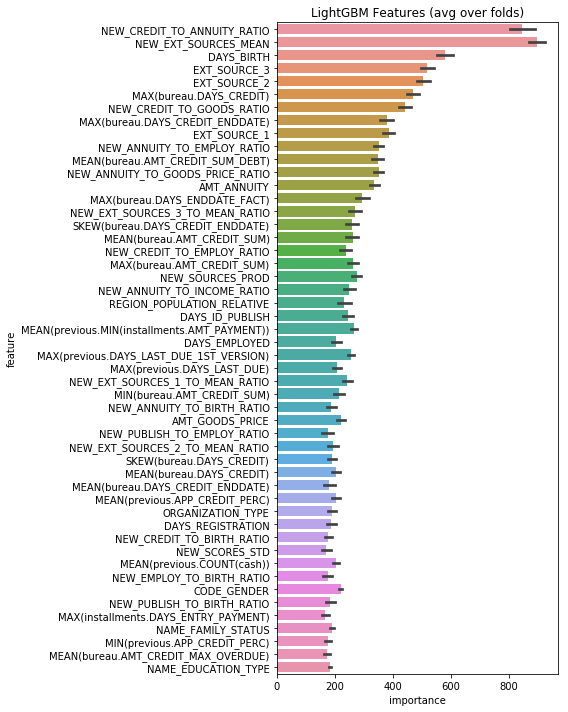

In [9]:
display_importances(feature_importance_df)

In [10]:
time.time() - st

12061.691976547241